# Paper Implementation: An Improved Collaborative Filtering Recommendation Algorithm and Recommendation Strategy

This project is based on the paper “An Improved Collaborative Filtering Recommendation Algorithm and Recommendation Strategy” by Xiaofeng Li and Dong Li. All research rights and intellectual property belong to the original authors under the Creative Commons Attribution License. We—Matteo and Julian, students at the University of Bolzano—have chosen this work as the foundation for a full analysis and software implementation of its proposed methods, in order to both validate and extend its contributions to community‑aware collaborative filtering.

## 1. Introduction

Li & Li (2019) address key limitations of traditional collaborative filtering (CF)—data sparsity, cold start, and scalability—by integrating overlapping community detection into the CF pipeline. They propose two algorithms to mine user communities from a social network projection of user–item interactions (central‑node‐based and k‑faction). By localizing neighbor selection within these communities and combining rating‐based similarity with category‐based similarity, they demonstrate significant reductions in MAE and RMSE on MovieLens‑100K.

## 2. Implementation Roadmap

Below is our high‑level plan to reproduce and extend Li & Li’s community‑aware CF framework:

1. **Dataset Preparation**
    - Download and preprocess the MovieLens 100K dataset.
    - Build the user–item rating matrix.
    - Build the User–Genre Preference Matrix

2. **Community Detection**
   1. **Central‑Node Algorithm**
      - Compute node degrees; seed each community with the highest‑degree node.
      - Iteratively add neighbors that maximize the local contribution \(q\).
      - Merge any two communities whose overlap \(S \ge 0.7\).
   2. **k‑Faction Algorithm**
      - Use Bron–Kerbosch to extract all cliques of size ≥*k*.
      - Merge cliques based on an overlap threshold \(T\) and inter‑community connectivity.
      - Assign remaining nodes to their closest community; refine by maximizing modularity \(Q_c\).

3. **Community‑Based Collaborative Filtering**
   - For each target user, restrict neighbor search to their detected community.
   - Construct a user–category binary matrix (e.g. item genres or tags).
   - Compute hybrid similarity:
     \[
       \text{sim}(u,v) = (1 - \lambda)\,\text{sim}_R(u,v) + \lambda\,\text{sim}_{\text{cate}}(u,v).
     \]
   - Predict ratings by aggregating the top‑*K* most similar users’ ratings.

4. **Evaluation Framework**
   - Perform 5‑fold cross‑validation with varying training:test splits (20–80%).
   - Measure MAE and RMSE for:
     - **CFCD** (Community‑based CF)
     - **CFC** (Cosine CF)
     - **CFP** (Pearson CF)

5. **Parameter Tuning & Experiments**
   - **Experiment1:** Fix *K* = 30; vary train:test ratio → assess sparsity impact.
   - **Experiment2:** Fix training ratio at 80%; vary *K* → find optimal neighbor set size.

6. **Optimizations & Extensions**
   - Scale community detection to large graphs (e.g. using NetworkX/igraph).
   - Incorporate implicit feedback (timestamps, clicks).
   - Prototype a real‑time recommendation pipeline with incremental updates.
   - Explore deep‑learning–based community embeddings as an alternative to classic detection.

7. **Documentation & Reporting**
   - Write clear API docs and usage examples for each module.
   - Produce reproducible scripts and Jupyter notebooks.
   - Summarize results with tables, charts, and a discussion of future work.

In [1]:
%%capture
%pip install pandas numpy surprise scikit-learn networkx matplotlib

In [2]:
import pandas as pd
import time
import math
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import urllib.request
import io
import zipfile
from networkx.algorithms.clique import find_cliques

RNG = 0

## Step 1: Dataset Preparation

### Step 1.1: Download and Preprocess

In this first step we download and preprocess the MovieLens100K dataset, originally collected by the GroupLens Research Project at the University of Minnesota. The data consists of 100000 integer ratings (1–5) from 943 users on 1682 movies (each user has rated at least 20 titles), along with simple demographic information (age, gender, occupation, ZIP code) and detailed movie–genre tags.

After downloading the raw data files, we load them into pandas DataFrames:

- **Ratings** (`u.data`): Load `u.data` (tab-separated) with columns `user_id, item_id, rating, timestamp`, then immediately drop the timestamp column since we only need the rating values.

- **Users** (`u.user`): Load `u.user` (pipe-separated) with columns `user_id, age, gender, occupation, zip_code`, then drop zip_code because demographic location isn’t required for our CF experiments.

- **Items** (`u.item`): Load `u.item` (pipe-separated) with columns `item_id, title, release_date, na, URL, plus the 19 genre` indicator columns. Immediately drop title, release_date, na, and URL—we only keep the binary genre flags for category-based similarity.

In [3]:
# Step 1: Load and preprocess MovieLens 100K ratings
ratings_path100k = './Data/ml-100k/u.data'
users_path100k = './Data/ml-100k/u.user'
items_path100k = './Data/ml-100k/u.item'

# Read raw ratings file
ratings = pd.read_csv(ratings_path100k, sep='\t', names=["user_id", "item_id", "rating", "timestamp"]).drop(columns=["timestamp"])
users = pd.read_csv(users_path100k, sep='|', names=["user_id", "age", "gender", "occupation", "zip_code"]).drop(columns=["zip_code"])
items = pd.read_csv(items_path100k, sep='|', names=["item_id", "title", "release_date", "na", "URL", "unknown", "Action", "Adventure", "Animation", "Children", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]).drop(columns=["title", "release_date", "na", "URL"])

Now let's observe the three dataframes:

In [4]:
print(f"Ratings shape: {ratings.shape}")
ratings.head()

Ratings shape: (100000, 3)


,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [5]:
print(f"Users shape: {users.shape}")
users.head()

Users shape: (943, 4)


,user_id,age,gender,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer
3,4,24,M,technician
4,5,33,F,other


In [6]:
print(f"Items shape: {items.shape}")
items.head()

Items shape: (1682, 20)


,item_id,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


### Step 1.2: Build the User–Item Rating Matrix

We reshape the ratings DataFrame into a 2D matrix where each of the 943 rows corresponds to a user and each of the 1682 columns to a movie, using the observed ratings as cell values. Any missing entries are filled with zero, signaling “no feedback.” This dense matrix format is required for efficient neighbor searches and similarity computations in the collaborative-filtering algorithms. Finally, we display the top-left 5×5 block to quickly verify that the pivot and fillna(0) operations produced the expected structure.

In [7]:
# Build user-item rating matrix
rating_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Display a small part of the rating matrix
print("\nUser-Item Rating Matrix (first 5 users, first 5 items):")
display(rating_matrix.iloc[:5, :5])


User-Item Rating Matrix (first 5 users, first 5 items):


item_id,1,2,3,4,5
user_id,,,,,
1,5.0,3.0,4.0,3.0,3.0
2,4.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0


### Step 1.3: Build the User–Genre Preference Matrix

In this step, we merge each user’s ratings with the corresponding movie’s 19 binary genre flags, then weight those flags by the actual rating so that only liked genres contribute and stronger likes count more. We group by user to compute the average rating per genre—summing weighted flags and dividing by the count of rated movies in each genre and finally threshold those averages at 3.5 to produce a binary indicator of “preferred” genres. The resulting 943×19 matrix captures each user’s high-level taste profile, ready for use in our hybrid similarity calculations.

In [8]:
def build_user_genre_matrix(ratings, items, threshold=3.5):
    # Merge ratings with item genre info
    merged = ratings.merge(items, on='item_id')

    # Get list of genre columns (assuming they are all except 'item_id')
    genre_columns = [col for col in items.columns if col != 'item_id']

    # Multiply ratings with genre indicators
    for genre in genre_columns:
        merged[genre] = merged[genre] * merged['rating']

    # Group by user and compute average rating per genre
    genre_sums = merged.groupby('user_id')[genre_columns].sum()
    genre_counts = merged.groupby('user_id')[genre_columns].apply(lambda x: (x != 0).sum())
    genre_avgs = genre_sums / genre_counts

    # Binary thresholding
    user_genre_binary = (genre_avgs > threshold).astype(int)

    user_genre_binary.index.name = 'user_id'

    return user_genre_binary

After defining the function that will generate the Binary User Genre Matrix we can generate the actual matrix.

In [9]:
binary_user_genre_matrix = build_user_genre_matrix(ratings, items, threshold=3.5)
print(f"User Genre Matrix shape: {binary_user_genre_matrix.shape}")
binary_user_genre_matrix.head()

User Genre Matrix shape: (943, 19)


,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1
2,0,1,1,1,0,1,1,0,1,0,1,0,0,0,1,1,1,1,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,0
5,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


## Step 2: Community Detection Algorithms

### Step 2.1: Central‑Node Overlapping Community Detection Algorithm

In this step we extract overlapping user communities from the user–item interaction graph by seeding each community with the unlabeled node of highest degree (“central node”), then growing it by iteratively adding the neighbor that maximizes the local contribution
`q = Lin / (Lin + Lout)`
(where `Lin` is the count of edges inside the candidate community and `Lout` is the count of edges from that community to the rest of the graph). Expansion stops when no neighbor can increase `q` (the global contribution `Q` is the highest `q` found). Finally, any two communities whose overlap
`S(Ci, Cj) = |Ci ∩ Cj| / |Ci ∪ Cj|`
exceeds 0.7 are merged, repeating until stable. The output is a set of densely connected, overlapping communities to be used as localized neighbor pools in our collaborative‑filtering stage.



In [10]:
def local_contribution(G, C, node):
    """Calculate local contribution q for adding node to community C."""
    C_union = C | {node}
    subgraph = G.subgraph(C_union)
    Lin = subgraph.number_of_edges()
    Lout = sum(1 for u in C_union for v in G.neighbors(u) if v not in C_union)
    return Lin / (Lin + Lout) if (Lin + Lout) > 0 else 0

def community_mining(G):
    """Stage 1: Detect initial overlapping communities based on central nodes."""
    labeled = set()
    communities = []

    while len(labeled) < G.number_of_nodes():
        # Pick highest-degree unlabeled node as seed
        candidates = [n for n in G.nodes if n not in labeled]
        seed = max(candidates, key=G.degree)
        C = {seed}
        labeled.add(seed)
        Q = 0

        while True:
            neighbors = {v for u in C for v in G.neighbors(u) if v not in C}
            if not neighbors:
                break

            contributions = {j: local_contribution(G, C, j) for j in neighbors}
            j_star, q_max = max(contributions.items(), key=lambda item: item[1])

            if q_max >= Q:
                C.add(j_star)
                labeled.add(j_star)
                Q = q_max
            else:
                break

        communities.append(C)
    return communities

def merge_overlapping_communities(communities, threshold=0.7):
    """Stage 2: Merge communities with high overlap."""
    merged = True
    while merged:
        merged = False
        new_communities = []
        used = [False] * len(communities)

        for i, Ci in enumerate(communities):
            if used[i]:
                continue
            merged_comm = set(Ci)
            used[i] = True

            for j in range(i + 1, len(communities)):
                if used[j]:
                    continue
                Cj = communities[j]
                S = len(merged_comm & Cj) / len(merged_comm | Cj)
                if S >= threshold:
                    merged_comm |= Cj
                    used[j] = True
                    merged = True

            new_communities.append(merged_comm)

        communities = new_communities
    return communities

def central_node_overlapping_communities(G, overlap_threshold=0.7):
    """
    Central-node based overlapping community detection.
    Args:
        G: networkx Graph
        overlap_threshold: overlap ratio to merge communities
    Returns:
        List of sets, each a community
    """
    initial_comms = community_mining(G)
    final_comms = merge_overlapping_communities(initial_comms, threshold=overlap_threshold)
    return final_comms

### Step 2.2: k‑Faction Algorithm

The algorithm begins by identifying all maximal cliques of size ≥ k in the user–user graph G, treating each clique as an initial “faction” of tightly connected users. Any two cliques whose overlap ratio defined as the size of their intersection divided by the size of the smaller clique meets or exceeds the threshold T are merged into a single community. This ensures that highly similar or nested cliques coalesce rather than remain separate.

Next, the method iteratively merges community pairs based on their inter-connectivity: for two communities C₁ and C₂, we count the actual edges between members of C₁ and C₂ and normalize by the total possible cross-community edges. If this connectivity fraction ≥ CONN, the two communities fuse. Once no further merges occur, any nodes not yet assigned (those not in any merged community) are individually attached to the community with which they share the most neighbors; truly isolated nodes form singleton communities. The result is an overlapping, variable-sized partitioning of the network that captures both dense cliques and broader, well-connected user groups.

In [11]:
def k_faction_community_detection(G, k=4, T=0.6, CONN=0.5):
    # Step 1: Find maximal cliques (factions)
    cliques = [set(c) for c in find_cliques(G) if len(c) >= k]

    # Step 2: Merge overlapping cliques into initial communities
    communities = []
    for clique in cliques:
        merged = False
        for i, existing in enumerate(communities):
            overlap = len(clique & existing) / min(len(clique), len(existing))
            if overlap >= T:
                communities[i] = existing | clique
                merged = True
                break
        if not merged:
            communities.append(clique)

    # Step 3: Merge communities based on connectivity
    def interconnectivity(comm1, comm2):
        inter_edges = 0
        total_edges = 0
        for u in comm1:
            for v in comm2:
                if G.has_edge(u, v):
                    inter_edges += 1
        total_edges = len(comm1) * len(comm2)
        return inter_edges / total_edges if total_edges else 0

    merged_flag = True
    while merged_flag:
        merged_flag = False
        new_communities = []
        skip = set()
        for i in range(len(communities)):
            if i in skip:
                continue
            for j in range(i + 1, len(communities)):
                if j in skip:
                    continue
                conn = interconnectivity(communities[i], communities[j])
                if conn >= CONN:
                    merged = communities[i] | communities[j]
                    new_communities.append(merged)
                    skip.update({i, j})
                    merged_flag = True
                    break
            if i not in skip:
                new_communities.append(communities[i])
        communities = new_communities

    # Step 4: Assign remaining nodes
    assigned = set().union(*communities)
    unassigned = set(G.nodes()) - assigned
    for node in unassigned:
        best_comm = None
        max_conn = -1
        for comm in communities:
            conn = sum(1 for neighbor in G.neighbors(node) if neighbor in comm)
            if conn > max_conn:
                max_conn = conn
                best_comm = comm
        if best_comm is not None:
            best_comm.add(node)
        else:
            communities.append({node})  # Isolated node gets its own community

    return communities


In [20]:
def load_graph(gml_path):
    # Rimuovi eventuale prima riga di commento e carica il grafo
    with open(gml_path) as f:
        lines = f.read().splitlines()

    if lines[0].startswith('#'):
        gml_content = '\n'.join(lines[1:])
        return nx.parse_gml(gml_content)
    else:
        return nx.read_gml(gml_path)

def relabel_nodes_to_integers(G, start=0, sort_nodes=False):
    """
    Relabel all nodes in a graph to integer IDs.

    Args:
        G           : input networkx Graph
        start       : integer to start labeling from (default 0)
        sort_nodes  : if True, sort original node labels for consistent order

    Returns:
        G_int   : new Graph with integer node labels
        mapping : dict mapping original_label -> new_integer_label

    Notes:
        - The original labels are stored as a node attribute 'original_label' in G_int.
        - If sort_nodes=False, enumeration follows G.nodes() order.
        - If sort_nodes=True, nodes are mapped in sorted order of their labels.
    """
    # Determine ordering of original nodes
    if sort_nodes:
        original_nodes = sorted(G.nodes())
    else:
        original_nodes = list(G.nodes())

    # Build mapping: original -> integer
    mapping = {orig: i + start for i, orig in enumerate(original_nodes)}

    # Relabel nodes to integers
    G_int = nx.relabel_nodes(G, mapping, copy=True)

    # Preserve original labels as attribute
    orig_attr = {new: orig for orig, new in mapping.items()}
    nx.set_node_attributes(G_int, orig_attr, name='original_label')

    return G_int, mapping

def clustered_layout(G, communities, scale=6.0, layout_k=0.3, iterations=200, seed=RNG):
    """
    Compute positions for each community cluster around a circle.

    Args:
        G             : networkx Graph
        communities   : list of sets, each set is a community of nodes
        scale         : radius of the circle on which clusters lie
        layout_k      : spring_layout 'k' parameter for internal spacing
        iterations    : number of iterations for spring_layout
        seed          : RNG seed for reproducibility

    Returns:
        pos : dict mapping node -> (x, y) position
    """
    pos = {}
    n = len(communities)

    # Position each community on a circle
    for i, comm in enumerate(communities):
        # Subgraph for this community
        subG = G.subgraph(comm)
        # Internal layout for subgraph
        sub_pos = nx.spring_layout(
            subG,
            k=layout_k,
            iterations=iterations,
            seed=seed
        )
        # Compute circular shift
        angle = 2 * math.pi * i / n
        shift_x = scale * math.cos(angle)
        shift_y = scale * math.sin(angle)

        # Apply shift to each node in this community
        for node, (x, y) in sub_pos.items():
            pos[node] = (x + shift_x, y + shift_y)

    return pos

def plot_with_dynamic_overlap(
    G, communities, title,
    scale=6.0, layout_k=0.3, overlap_scale=1.0,
    iterations=200, figsize=(8, 6), cmap='tab20', show_labels=True, seed=RNG
):
    """
    Plot communities with overlapping nodes highlighted and spread dynamically.

    Overlapping nodes are those that appear in more than one community.
    They are laid out together in their own small spring layout at center.
    """
    # Count memberships to detect overlap
    membership = Counter(node for comm in communities for node in comm)
    overlapping = [node for node, count in membership.items() if count > 1]
    # Remove overlapping from base communities
    base_comms = [set(comm) - set(overlapping) for comm in communities]

    # Compute positions for base (non-overlapping) communities
    pos = clustered_layout(
        G, base_comms,
        scale=scale,
        layout_k=layout_k,
        iterations=iterations,
        seed=seed
    )

    # Compute central layout for overlapping nodes
    if overlapping:
        subG = G.subgraph(overlapping)
        sub_pos = nx.spring_layout(
            subG,
            k=layout_k,
            iterations=iterations,
            seed=seed
        )
        # Scale and center the overlapping cluster
        for node, (x, y) in sub_pos.items():
            pos[node] = (x * overlap_scale, y * overlap_scale)

    # Draw figure
    plt.figure(figsize=figsize)

    # Draw each base community with distinct color
    for idx, comm in enumerate(base_comms):
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=list(comm),
            node_color=[idx] * len(comm),
            cmap=cmap,
            vmin=0, vmax=len(base_comms) - 1,
            node_size=300,
            label=f'Comm {idx+1}'
        )

    # Draw overlapping nodes in red
    if overlapping:
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=overlapping,
            node_color='red',
            node_size=300,
            label='Overlap'
        )

    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    if show_labels:
        nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(title)
    plt.axis('off')
    plt.legend(loc='best', scatterpoints=1)
    plt.show()

def elaborate_graphs(
    G, k=4, T=0.6, CONN=0.5, scale=2.0, layout_k=0.3, overlap_scale=1.0, iterations=200, show_labels=True, seed=RNG
):
    """
    Detect and visualize communities using both Central-Node and k-Faction algorithms.

    Prints community lists for verification, then plots each result.
    """
    # Central-Node detection
    start_cn = time.perf_counter()
    cn_comms = central_node_overlapping_communities(G, overlap_threshold=T)
    t_cn = time.perf_counter() - start_cn

    print("Central-Node detected communities:")
    for i, comm in enumerate(cn_comms, 1):
        print(f"  Community {i}: {sorted(comm)}")

    # Plot with overlap handling
    plot_with_dynamic_overlap(
        G, cn_comms,
        title=f'Central-Node (t={t_cn:.4f}s)',
        scale=scale,
        layout_k=layout_k,
        overlap_scale=overlap_scale,
        iterations=iterations,
        show_labels=show_labels,
        seed=seed
    )

    # k-Faction detection
    start_kf = time.perf_counter()
    kf_comms = k_faction_community_detection(G, k=k, T=T, CONN=CONN)
    t_kf = time.perf_counter() - start_kf

    print("\nk-Faction detected communities:")
    for i, comm in enumerate(kf_comms, 1):
        print(f"  Community {i}: {sorted(comm)}")

    plot_with_dynamic_overlap(
        G, kf_comms,
        title=f'k-Faction (t={t_kf:.4f}s)',
        scale=scale,
        layout_k=layout_k,
        overlap_scale=overlap_scale,
        iterations=iterations,
        show_labels=show_labels,
        seed=seed
    )

Central-Node detected communities:
  Community 1: [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  Community 2: [0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 17, 19, 21, 30]
  Community 3: [4, 5, 6, 10, 16]


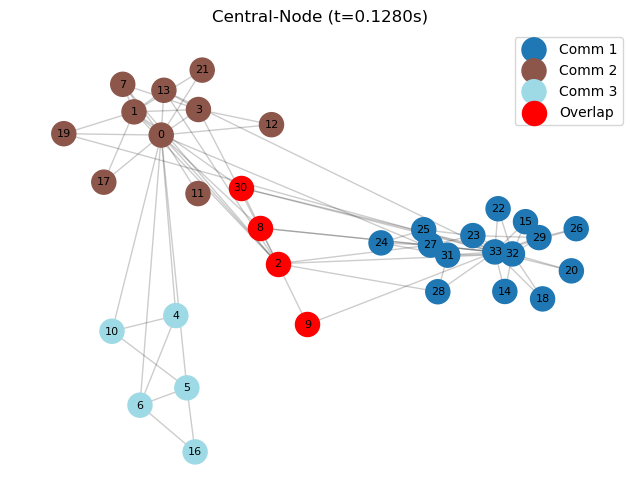


k-Faction detected communities:
  Community 1: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21, 24, 25, 27, 28, 31]
  Community 2: [8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]


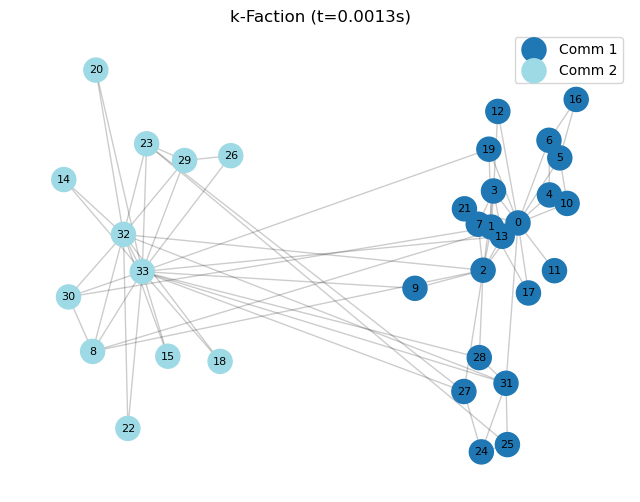

In [13]:
elaborate_graphs(nx.karate_club_graph())

Central-Node detected communities:
  Community 1: [0, 4, 9, 16, 23, 41, 67, 90, 93, 104]
  Community 2: [1, 25, 33, 37, 45, 89, 103, 105, 109]
  Community 3: [2, 6, 13, 14, 15, 32, 39, 47, 60, 64, 100, 106]
  Community 4: [3, 4, 5, 10, 11, 24, 28, 36, 40, 50, 52, 58, 59, 63, 69, 72, 74, 81, 84, 90, 97, 98, 102, 107]
  Community 5: [7, 8, 21, 22, 51, 68, 77, 78, 108, 111]
  Community 6: [3, 5, 10, 40, 52, 53, 72, 74, 81, 84, 88, 98, 102, 107]
  Community 7: [17, 20, 27, 56, 62, 65, 70, 76, 87, 95, 96, 113]
  Community 8: [12, 14, 18, 19, 26, 31, 34, 36, 38, 42, 43, 54, 61, 71, 80, 85, 99]
  Community 9: [19, 29, 30, 35, 36, 42, 55, 58, 59, 63, 79, 94, 97, 101]
  Community 10: [44, 48, 57, 66, 75, 86, 91, 92, 112]
  Community 11: [46, 49, 53, 67, 73, 83, 88, 110, 114]
  Community 12: [19, 29, 30, 35, 55, 79, 80, 82, 93, 94, 101]


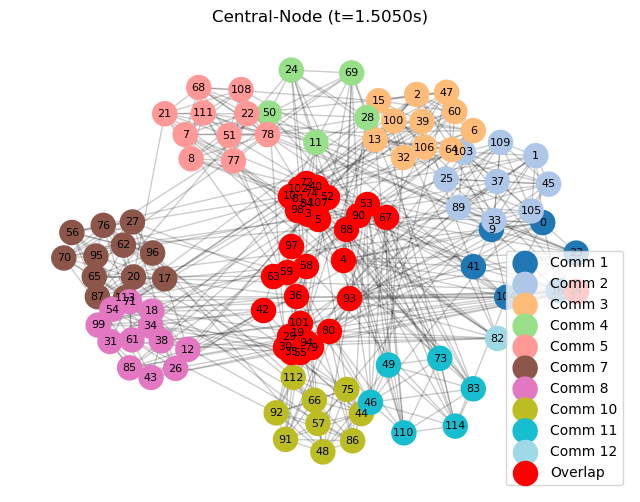


k-Faction detected communities:
  Community 1: [0, 4, 9, 16, 23, 41, 67, 93, 104]
  Community 2: [2, 6, 13, 15, 32, 39, 47, 60, 64, 100, 106]
  Community 3: [2, 3, 5, 10, 40, 52, 72, 74, 81, 84, 98, 102, 107]
  Community 4: [7, 8, 21, 22, 50, 51, 68, 77, 78, 108, 111]
  Community 5: [11, 24, 28, 50, 69, 90]
  Community 6: [12, 14, 26, 36, 38, 42, 43, 85]
  Community 7: [14, 18, 31, 34, 38, 54, 61, 71, 99]
  Community 8: [17, 20, 27, 56, 62, 65, 70, 76, 87, 95, 96, 113]
  Community 9: [19, 29, 30, 35, 44, 55, 79, 80, 82, 94, 101]
  Community 10: [1, 25, 33, 37, 45, 89, 103, 105, 109]
  Community 11: [44, 48, 57, 66, 75, 86, 91, 92, 112]
  Community 12: [46, 49, 53, 67, 73, 83, 88, 110, 114]
  Community 13: [58, 59, 63, 97]


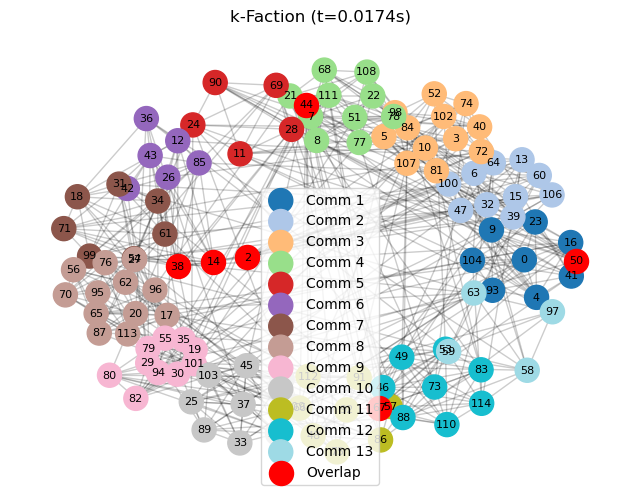

In [33]:
# Percorso al file GML nella cartella 'data'
american_footbal_graph, _ = relabel_nodes_to_integers(load_graph('Data/Football_Graph/football.gml'))
elaborate_graphs(american_footbal_graph, scale=4, layout_k=0.8, overlap_scale=5)

Central-Node detected communities:
  Community 1: ['Beak', 'Bumper', 'CCL', 'Cross', 'Double', 'Fish', 'Five', 'Fork', 'Grin', 'Haecksel', 'Hook', 'Jonah', 'Kringel', 'MN105', 'MN60', 'MN83', 'Oscar', 'PL', 'Patchback', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'SN96', 'Scabs', 'Shmuddel', 'Stripes', 'TR120', 'TR77', 'TR88', 'TR99', 'TSN103', 'TSN83', 'Thumper', 'Topless', 'Trigger', 'Vau', 'Whitetip', 'Zap', 'Zipfel']
  Community 2: ['Beescratch', 'Jet', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi']
  Community 3: ['DN16', 'DN21', 'Feather', 'Gallatin', 'Jet', 'MN23', 'Quasi', 'Ripplefluke', 'SN89', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']
  Community 4: ['Beescratch', 'DN63', 'Knit', 'Mus', 'Notch', 'Number1', 'Oscar', 'PL', 'SN90', 'Upbang']


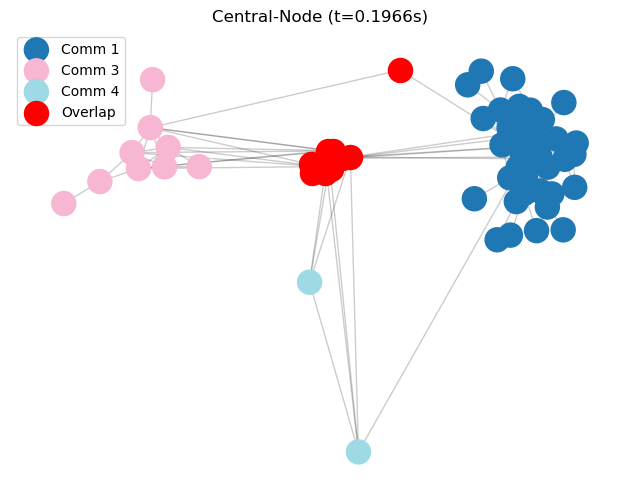


k-Faction detected communities:
  Community 1: ['Cross', 'Five', 'Haecksel', 'Jonah', 'MN105', 'MN60', 'MN83', 'Mus', 'Notch', 'Patchback', 'SMN5', 'Topless', 'Trigger', 'Vau']
  Community 2: ['Beak', 'Bumper', 'Fish', 'PL', 'SN96', 'TR77']
  Community 3: ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Number1', 'Quasi', 'Ripplefluke', 'SN89', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']
  Community 4: ['CCL', 'Double', 'Fork', 'Grin', 'Hook', 'Kringel', 'Oscar', 'SN100', 'SN4', 'SN63', 'SN9', 'Scabs', 'Shmuddel', 'Stripes', 'TR120', 'TR88', 'TR99', 'TSN103', 'TSN83', 'Thumper', 'Whitetip', 'Zap', 'Zipfel']


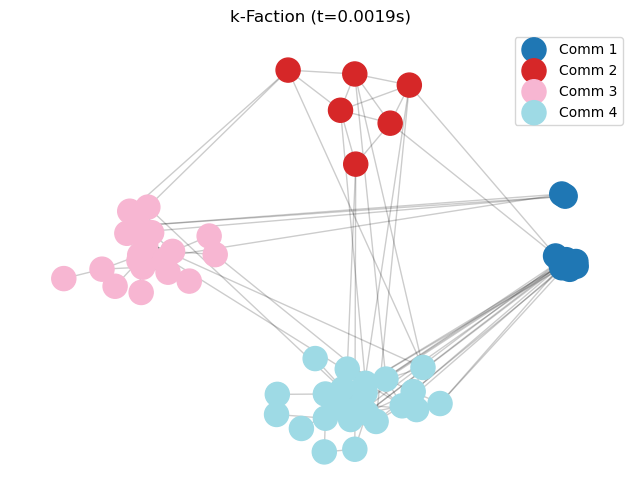

In [19]:
# Percorso al file GML nella cartella 'data'
dolphins_graph = load_graph('Data/Dolphin_Graph/dolphins.gml')
elaborate_graphs(dolphins_graph, scale=2.5, layout_k=0.5, show_labels=False)

### Constructing the user-user network

In [30]:
from collections import defaultdict
import networkx as nx

def build_user_item_bipartite(ratings):
    B = nx.Graph()
    for _, row in ratings.iterrows():
        user = f'u{row["user_id"]}'
        item = f'i{row["item_id"]}'
        B.add_node(user, bipartite=0)
        B.add_node(item, bipartite=1)
        B.add_edge(user, item)
    return B

In [31]:
from networkx.algorithms import bipartite

def project_user_graph(B):
    users = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
    G_user = bipartite.weighted_projected_graph(B, users)
    return G_user

In [6]:
def filter_user_graph(G_user, min_common=5):
    G_filtered = nx.Graph()

    # Add strong edges (based on co-rated items)
    for u, v, data in G_user.edges(data=True):
        if data['weight'] >= min_common:
            G_filtered.add_edge(u, v, weight=data['weight'])

    # Re-add all user nodes (even if isolated)
    #G_filtered.add_nodes_from(G_user.nodes(data=True))  # keep attributes if any

    return G_filtered

In [10]:
B = build_user_item_bipartite(ratings)
G_user = project_user_graph(B)
G_filtered = filter_user_graph(G_user, min_common=20)
print(f"Projected user-user graph has {G_filtered.number_of_nodes()} nodes and {G_filtered.number_of_edges()} edges.")

Projected user-user graph has 908 nodes and 123565 edges.


In [ ]:
"""comms = central_node_overlapping_communities(G_filtered)
print("Detected communities:")
for i, comm in enumerate(comms, 1):
    print("Community of size", len(comm))
    print(f"Community {i}: {sorted(comm)}")"""

In [11]:
communities = k_faction_community_detection(G_filtered, k=4, T=0.7, CONN=0.7)
print(f"Detected {len(communities)} communities")

for i, comm in enumerate(communities, 1):  # Show first 5
    print("Community of size", len(comm))
    print(f"Community {i}: {sorted(comm)}")

KeyboardInterrupt: 

## User network based on user tag attributes

In [32]:
import pandas as pd
import networkx as nx

def zip_similarity(zip1, zip2):
    zip1, zip2 = str(zip1), str(zip2)
    return sum(c1 == c2 for c1, c2 in zip(zip1[:3], zip2[:3])) / 3

def demographic_similarity(u1, u2, weights):
    age_sim = max(0, 1 - abs(u1.age - u2.age) / 50)
    gender_sim = 1 if u1.gender == u2.gender else 0
    occupation_sim = 1 if u1.occupation == u2.occupation else 0

    return (weights['age'] * age_sim +
            weights['gender'] * gender_sim +
            weights['occupation'] * occupation_sim)

def build_weighted_user_graph(users, weights, threshold=0.5):
    G = nx.Graph()
    for _, row in users.iterrows():
        G.add_node(row.user_id, age=row.age, gender=row.gender,
                   occupation=row.occupation, zip_code=row.zip_code)

    for i, u1 in users.iterrows():
        for j, u2 in users.iterrows():
            if i >= j:
                continue
            sim = demographic_similarity(u1, u2, weights)
            if sim >= threshold:
                G.add_edge(u1.user_id, u2.user_id, weight=sim)
    return G


In [33]:
users = pd.read_csv("Data/ml-100k/u.user", sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

weights = {
    'age': 0.4,
    'gender': 0.3,
    'occupation': 0.3
}

G_weighted = build_weighted_user_graph(users, weights, threshold=0.7)

print(f"Weighted user graph: {G_weighted.number_of_nodes()} nodes, {G_weighted.number_of_edges()} edges")

Weighted user graph: 943 nodes, 30982 edges


In [34]:
communities = k_faction_community_detection(G_weighted, k=20, T=0.5, CONN=0.5)
print(f"Detected {len(communities)} communities")

sum_c = 0
for i, comm in enumerate(communities, 1):
    sum_c += len(comm)# Show first 5
    print("Community of size", len(comm))
    print(f"Community {i}: {sorted(comm)}")

sum_c

Detected 28 communities
Community of size 44
Community 1: [1, 4, 31, 39, 69, 73, 75, 105, 106, 132, 179, 234, 268, 293, 301, 308, 318, 349, 369, 414, 431, 435, 456, 470, 472, 480, 481, 517, 564, 567, 573, 627, 641, 644, 651, 717, 752, 832, 860, 867, 889, 900, 926, 936]
Community of size 31
Community 2: [1, 4, 44, 77, 143, 197, 211, 244, 294, 311, 325, 339, 441, 443, 456, 458, 488, 545, 670, 690, 715, 717, 718, 738, 739, 753, 790, 812, 832, 850, 889]
Community of size 59
Community 3: [2, 5, 11, 12, 18, 20, 38, 46, 120, 126, 128, 129, 149, 155, 165, 169, 236, 256, 273, 292, 316, 342, 352, 362, 373, 376, 389, 417, 418, 424, 437, 460, 505, 544, 602, 613, 617, 629, 681, 698, 713, 719, 721, 732, 733, 734, 751, 760, 797, 805, 809, 810, 835, 856, 859, 885, 907, 914, 930]
Community of size 26
Community 4: [3, 21, 22, 28, 50, 196, 199, 201, 293, 370, 385, 392, 445, 464, 498, 548, 695, 741, 745, 772, 801, 829, 833, 842, 853, 896]
Community of size 22
Community 5: [3, 33, 37, 66, 135, 255, 267, 30

1222

## Step 3: Community‑Based Collaborative Filtering

In [36]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def corrected_cosine_similarity(matrix):
    # Subtract mean rating per user (row-wise mean)
    matrix_centered = matrix - np.nanmean(matrix, axis=1, keepdims=True)
    # Replace NaNs with 0 for similarity calculation
    matrix_centered = np.nan_to_num(matrix_centered)
    return cosine_similarity(matrix_centered)


In [51]:
rating_matrix

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_combined_similarity_to_user(user_item_matrix, user_category_matrix, target_user, k=10, lambda_=0.5):
    # Ensure DataFrame row -> NumPy array
    target_rating_vector = user_item_matrix.iloc[target_user].values.reshape(1, -1)
    sim_r = cosine_similarity(target_rating_vector, user_item_matrix.values)[0]
    sim_r[target_user] = 0  # remove self-similarity

    target_category_vector = user_category_matrix.iloc[target_user].values.reshape(1, -1)
    sim_cat = cosine_similarity(target_category_vector, user_category_matrix.values)[0]
    sim_cat[target_user] = 0

    combined = (1 - lambda_) * sim_r + lambda_ * sim_cat
    top_k_users = np.argsort(combined)[-k:][::-1]

    return top_k_users, combined[top_k_users]


In [65]:
x, z = compute_combined_similarity_to_user(rating_matrix, binary_user_genre_matrix, 1)

In [86]:
def predict_rating(user_id, item_id, community, user_item_matrix, item_category_matrix, k=10, lambda_=0.5):
    if user_id not in community:
        # Fallback: average of non-zero ratings
        user_ratings = user_item_matrix.loc[user_id]
        rated = user_ratings != 0
        return user_ratings[rated].mean() if rated.any() else 0

    community_list = list(community)
    comm_user_item_matrix = user_item_matrix.loc[community_list]
    comm_item_cate_matrix = item_category_matrix.loc[community_list]


    user_idx_in_comm = community_list.index(user_id)


    top_k_rel, similarities = compute_combined_similarity_to_user(
        comm_user_item_matrix, comm_item_cate_matrix, user_idx_in_comm, k=k, lambda_=lambda_
    )

    comm_ids = list(comm_user_item_matrix.index)
    top_k_users = [comm_ids[i] for i in top_k_rel]

    # Get ratings for the target item
    ratings = user_item_matrix.loc[top_k_users, item_id]

    # Mask: only include real ratings (non-zero)
    mask = ratings != 0

    if mask.sum() == 0:
        user_ratings = user_item_matrix.loc[user_id]
        rated = user_ratings != 0
        return user_ratings[rated].mean() if rated.any() else 0

    valid_ratings = ratings[mask]
    valid_similarities = similarities[mask]

    weighted_sum = np.dot(valid_ratings, valid_similarities)
    sum_weights = np.sum(valid_similarities)

    return weighted_sum / sum_weights if sum_weights != 0 else user_ratings[rated].mean()

In [93]:
predict_rating(1, 6, communities[0], rating_matrix, binary_user_genre_matrix, k=10, lambda_=0.5)

3.610294117647059

In [88]:
rating_matrix 


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(test_df, communities, user_item_matrix, sim_matrix, k=30):
    preds, actuals = [], []

    # Pre-map each user to their community
    user_community = {}
    for c in communities:
        for u in c:
            user_community[int(u[1:])] = [int(n[1:]) for n in c]

    for _, row in test_df.iterrows():
        u, i, r = row['user_id'], row['item_id'], row['rating']
        comm = user_community.get(u, [])
        pred = predict_rating(u, i, comm, user_item_matrix, sim_matrix, k)
        preds.append(pred)
        actuals.append(r)

    mae = mean_absolute_error(actuals, preds)
    rmse = mean_squared_error(actuals, preds, squared=False)
    return mae, rmse


## Testing the approach

In [ ]:
communities = k_faction_community_detection(G_filtered, k=7, T=0.9, CONN=0.9)
print(f"Detected {len(communities)} communities")

for i, comm in enumerate(communities, 1):  # Show first 5
    print("Community of size", len(comm))
    print(f"Community {i}: {sorted(comm)}")